In [20]:
# import libraries
from cryptography.fernet import Fernet
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
import copy

In [2]:
# open the key file
with open('filekey.key', 'rb') as f:
  key = f.read()

In [4]:
# Store the file in an object named fernet
fernet = Fernet(key)

In [5]:
# Open the data file
with open('nutriboost_place_promo.csv', 'rb') as f:
  data = f.read()

In [6]:
# Decryption
decrypt_data = fernet.decrypt(data)

In [7]:
# Overwrite the decryption
with open('nutriboost_place_promo.csv', 'wb') as f:
  f.write(decrypt_data)

In [8]:
# Load the dataset
df = pd.read_csv('nutriboost_place_promo.csv')
df.head()

,CustomerID,Age,Income,WTP,Proximity,Channel_Satisfaction,Preferred_Channel,Promo_Response,Ad_Recall,Coupon_Usage,Brand_Engagement
0,1,24,7286710,127,3,1,Online,0,2,7,2
1,2,37,2591820,81,6,1,Gym,0,3,12,2
2,3,46,2218670,67,8,4,Supermarket,1,3,7,2
3,4,32,5978560,126,9,1,Convenience Store,0,3,93,3
4,5,28,8951690,117,7,4,Convenience Store,0,2,95,4


In [9]:
# Missing Values
df.isna().sum()

,0
CustomerID,0
Age,0
Income,0
WTP,0
Proximity,0
Channel_Satisfaction,0
Preferred_Channel,0
Promo_Response,0
Ad_Recall,0
Coupon_Usage,0


In [10]:
# Create the copy of the dataset
df_copy = df.copy(deep = True)
df_copy.head()

,CustomerID,Age,Income,WTP,Proximity,Channel_Satisfaction,Preferred_Channel,Promo_Response,Ad_Recall,Coupon_Usage,Brand_Engagement
0,1,24,7286710,127,3,1,Online,0,2,7,2
1,2,37,2591820,81,6,1,Gym,0,3,12,2
2,3,46,2218670,67,8,4,Supermarket,1,3,7,2
3,4,32,5978560,126,9,1,Convenience Store,0,3,93,3
4,5,28,8951690,117,7,4,Convenience Store,0,2,95,4


In [11]:
# Explore the column names
df_copy.columns

Index(['CustomerID', 'Age', 'Income', 'WTP', 'Proximity',
       'Channel_Satisfaction', 'Preferred_Channel', 'Promo_Response',
       'Ad_Recall', 'Coupon_Usage', 'Brand_Engagement'],
      dtype='object')

In [13]:
# Define the place columns
place_cols = ['Channel_Satisfaction', 'Preferred_Channel']

In [16]:
# Separate the categorical and numerical variables
categorical_col = ['Preferred_Channel']
numerical_col = ['Channel_Satisfaction']

In [18]:
# Preprocessing
place_preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(), categorical_col),
    ('num', StandardScaler(), numerical_col)
])

In [19]:
# Fit the preprocessor values in the dataset
df_scaled = place_preprocessor.fit_transform(df_copy)

In [24]:
# Inertia and Silhouette Score
inertia = []
silhouette = []
k_range = range(2,7)

for k in k_range:
  km = KMeans(n_clusters = k, random_state = 42)
  labels = km.fit_predict(df_scaled)
  inertia.append(km.inertia_)
  silhouette.append(silhouette_score(df_scaled, labels))

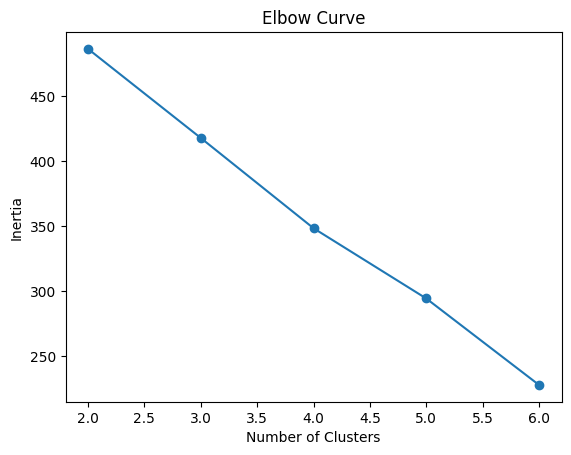

In [26]:
# Plot the elbw curve
plt.plot(k_range, inertia, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

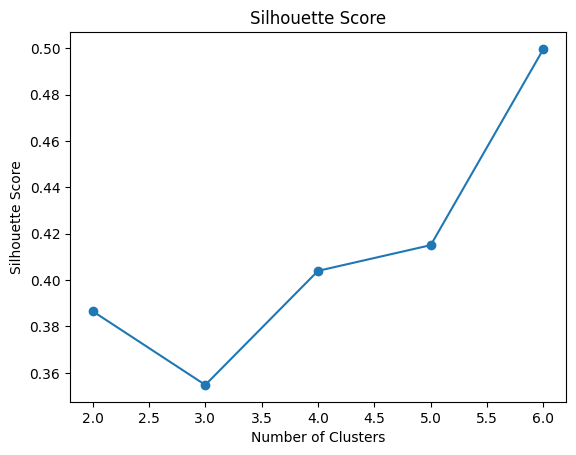

In [27]:
# Silhouette Score
plt.plot(k_range, silhouette, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In [28]:
# Best k
place_k = k_range[silhouette.index(max(silhouette))]
place_k

6

In [30]:
# Final Clustering
place_km = KMeans(n_clusters = place_k, random_state = 42)
df_copy['Place_Cluster'] = place_km.fit_predict(df_scaled)

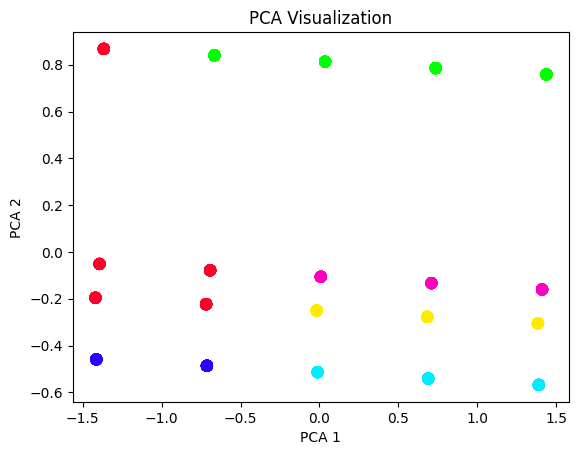

In [38]:
# PCA Visualization
pca = PCA(n_components = 2)
df_pca_scaled = pca.fit_transform(df_scaled.toarray() if hasattr(df_scaled, 'toarray') else df_scaled)
plt_scatter = plt.scatter(x = df_pca_scaled[:,0], y = df_pca_scaled[:,1], c = df_copy['Place_Cluster'], cmap = 'gist_rainbow', s= 60)
plt.title('PCA Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [42]:
# Interpretation
place_result = df_copy.groupby('Place_Cluster')['Preferred_Channel'].value_counts().sort_values(ascending = False)

idx = place_result.idxmax()
val = place_result.max()

print('Cluster and Channel with Max Share:', idx)
print('Count:', val)


Cluster and Channel with Max Share: (np.int32(2), 'Online')
Count: 115


In [43]:
# Identifying customers in clusters
for cluster in df_copy['Place_Cluster'].unique():
  print('Customers in Cluster', cluster)
  cluster_columns = df_copy[df_copy['Place_Cluster'] == cluster]
  print(cluster_columns[['CustomerID', 'Preferred_Channel', 'Channel_Satisfaction']].head(10))


Customers in Cluster 0
    CustomerID  Preferred_Channel  Channel_Satisfaction
0            1             Online                     1
1            2                Gym                     1
3            4  Convenience Store                     1
7            8                Gym                     2
8            9  Convenience Store                     2
10          11  Convenience Store                     1
11          12  Convenience Store                     2
12          13  Convenience Store                     1
13          14  Convenience Store                     1
14          15                Gym                     1
Customers in Cluster 3
    CustomerID Preferred_Channel  Channel_Satisfaction
2            3       Supermarket                     4
36          37       Supermarket                     4
38          39       Supermarket                     4
42          43       Supermarket                     4
53          54       Supermarket                     4
54      

In [44]:
df_copy.columns

Index(['CustomerID', 'Age', 'Income', 'WTP', 'Proximity',
       'Channel_Satisfaction', 'Preferred_Channel', 'Promo_Response',
       'Ad_Recall', 'Coupon_Usage', 'Brand_Engagement', 'Place_Cluster'],
      dtype='object')

In [45]:
# Promotion Cols
promo_cols = ['Promo_Response', 'Ad_Recall']

In [46]:
# Preprocessing
promo_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), promo_cols)
])

In [47]:
# Fit Tranform the dataset
promo_scaled = promo_preprocessor.fit_transform(df_copy)

In [48]:
# Inertia and Silhouette Score
inertia = []
silhouette = []
k_range = range(2,7)

for k in k_range:
  km = KMeans(n_clusters = k, random_state = 42)
  labels = km.fit_predict(promo_scaled)
  inertia.append(km.inertia_)
  silhouette.append(silhouette_score(promo_scaled, labels))

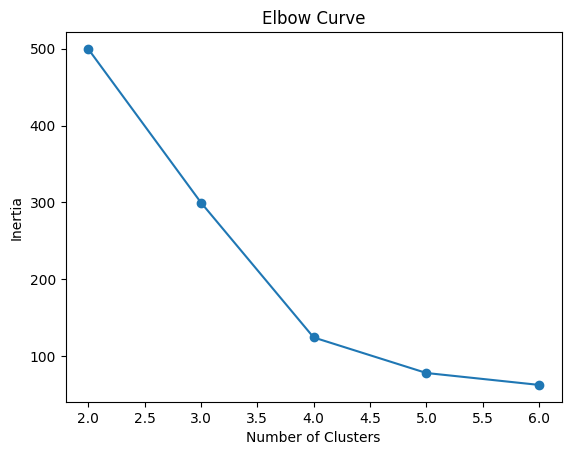

In [52]:
# Elbow Curve
plt.plot(k_range, inertia, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

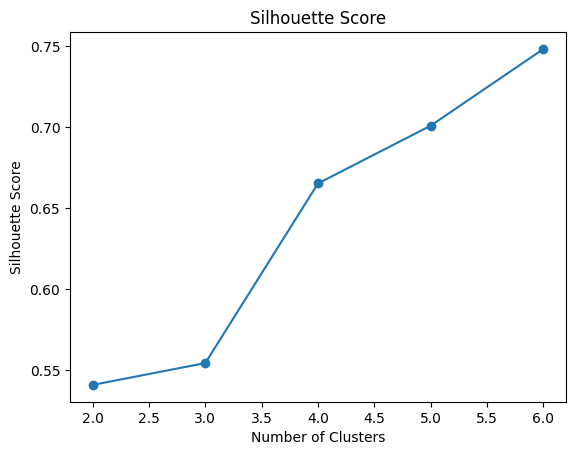

In [53]:
# Silhouette Score
plt.plot(k_range, silhouette, marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

In [54]:
# Best K Value
promo_k = k_range[silhouette.index(max(silhouette))]
promo_k

6

In [55]:
# Final Clustering
promo_km = KMeans(n_clusters = promo_k, random_state = 42)
df_copy['Promo_Cluster'] = promo_km.fit_predict(promo_scaled)

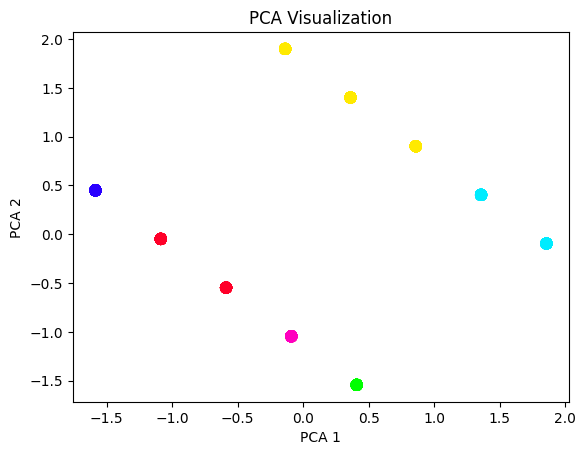

In [56]:
# PCA Visualization
pca = PCA(n_components = 2)
promo_pca_scaled = pca.fit_transform(promo_scaled.toarray() if hasattr(promo_scaled, 'toarray') else promo_scaled)
pca_scatter = plt.scatter(x = promo_pca_scaled[:,0], y = promo_pca_scaled[:,1], c = df_copy['Promo_Cluster'], cmap = 'gist_rainbow', s= 60)
plt.title('PCA Visualization')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [57]:
# Interpretation for Promo Response
df_copy.groupby('Promo_Cluster')['Promo_Response'].value_counts().sort_values(ascending = False)

,,count
Promo_Cluster,Promo_Response,
0,0,115
1,1,115
3,1,81
2,0,65
4,0,64
5,0,60


In [58]:
# Interpretation for Ad Recall
df_copy.groupby('Promo_Cluster')['Ad_Recall'].value_counts().sort_values(ascending = False)

Promo_Cluster  Ad_Recall
2              5            65
4              1            64
5              4            60
0              3            58
               2            57
1              3            44
3              4            41
               5            40
1              2            37
               1            34
Name: count, dtype: int64

In [59]:
# Cluster for each customer
for cluster in df_copy['Promo_Cluster'].unique():
  print('Customers in Cluster', cluster)
  cluster_columns = df_copy[df_copy['Promo_Cluster'] == cluster]
  print(cluster_columns[['CustomerID', 'Promo_Response', 'Ad_Recall']].head(10))

Customers in Cluster 0
    CustomerID  Promo_Response  Ad_Recall
0            1               0          2
1            2               0          3
3            4               0          3
4            5               0          2
5            6               0          3
6            7               0          2
7            8               0          3
18          19               0          3
20          21               0          2
39          40               0          3
Customers in Cluster 1
    CustomerID  Promo_Response  Ad_Recall
2            3               1          3
10          11               1          2
12          13               1          2
15          16               1          2
22          23               1          1
26          27               1          3
28          29               1          1
36          37               1          2
41          42               1          3
45          46               1          3
Customers in Cluster 2
    Cus